# 09/11/23 - Copied from 090623_jam_milestone_anisotropy_studies.ipynb
# I had the Vrms error incorrectly saved. This is a really insane thing.

#### 09/06/23 - Milestone studies for anisotropy constraints. For as many as I can make good models...  4 models each
##### Spherical and Axisymmetric
##### PL mass profile
##### OM and constant anisotropy


#### 05/19/23 - Copied from 012523_jam_bayes.ipynb. Testing the new implementation of anisotropy profiles from Michele. See https://mail.google.com/mail/u/0/?tab=rm&ogbl#search/osipkov/FMfcgzGrcFfBKDBKxwlvtkWlVRXdvklX
#### 05/22/23 - Corrected the "details_for_jampy.pkl" - ONLY FOR J0037 SN 15 so far
- surface brightness is now correctly computed from B-mag (I think)
- bin x and y coordinates rotated along the photometric axis are now correct (phot maj axis is x axis)

#### 05/25/23 - Starting a new notebook just to keep things cleaner.
#### 05/30/23 - Trying to improve things... See
https://mail.google.com/mail/u/0/?tab=rm&ogbl#sent/KtbxLwgddjZLmPGGgmbJhZRvDWrPbJPXpL
#### Today I'm going to try to implement it with emcee instead of adamet
#### 06/02/23 - Running AdaMet and Emcee with corrected photometry.
#### 06/07/23 - Copied from home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/jampy/060623_jam_bayes_emcee_pl_const_5obj.ipynb
#### 06/09/23 - Copied from home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/jampy/060723_jam_whole_story_J1204.ipynb
#### 06/13/23 - Actually doing the Einstein radius mass scaling
#### This notebook goes through tests on just J1204 to prepare a "whole story" for the Otranto conference.
#### Power law and composite, spherical and cylindrical, const and OM, SN 15
#### Introducing new methods for incorporating the MSD and mass scaling.
#### Mass scaling will be from the Einstein radius now.
#### I will now work with convergences and multiply by the critical density to get the surface brightness.
#### That is where the proper units come in.
#### 08/10/23 - Changing the break radius and mass sheet radius to check its effect.
##### Make sure const ani parameter [0,1] for cylindrical.
##### Save chi2 of bestfit model and look at distribution (model comparison, BIC, something with evidence comparison)
## 09/06/23 - copied from 081023_jam_J1204_f2f.ipynb
## Milestone studies for anisotropy constraints. For as many as I can make good models...  4 models each
## Spherical and Axisymmetric
## PL mass profile
## OM and constant anisotropy

In [1]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import os
from os import path
from pathlib import Path
import pickle
from datetime import datetime
def tick():
    return datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo # I took 15 because for some reason Planck18 isn't in this astropy install #Planck18 as cosmo  # Planck 2018
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import astropy.units as u
import astropy.constants as constants

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized

# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa
from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_radial_mass import mge_radial_mass
from plotbin.symmetrize_velfield import symmetrize_velfield

# adamet
from adamet.adamet import adamet
from adamet.corner_plot import corner_plot
# emcee
import emcee
import corner
from IPython.display import display, Math

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
from slacs_ani_mass_jam import osipkov_merritt_model
from slacs_ani_mass_jam import osipkov_merritt_generalized_model
from slacs_ani_mass_jam import inner_outer_anisotropy_model
from slacs_ani_mass_jam import nfw_generalized_model
from slacs_ani_mass_jam import dark_halo_mge
from slacs_ani_mass_jam import total_mass_mge
from slacs_ani_mass_jam import jam_lnprob
from slacs_ani_mass_jam import jam_lnprob_power_law
from slacs_ani_mass_jam import jam_lnprob_nfw_constbeta
from slacs_ani_mass_jam import jam_lnprob_nfwgen_constbeta
from slacs_ani_mass_jam import jam_lnprob_nfw_om
from slacs_ani_mass_jam import jam_lnprob_nfwgen_om
from slacs_ani_mass_jam import summary_plot
from slacs_ani_mass_jam import save_fit_parameters
from slacs_ani_mass_jam import get_power_law_slope
from slacs_ani_mass_jam import jampy_details
from slacs_ani_mass_jam import prepare_to_jam
from slacs_ani_mass_jam import space_jam
from slacs_mge_jampy import make_gaussian

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC
# B band (F435W) dust extinction ~ 0.116 from https://irsa.ipac.caltech.edu/applications/DUST/
#extinction = 0.116
### photometric zeropoint for F435W as of 2007 was 25.745
#photometric_zeropoint = 25.745
# redshift, convert to angular diameter dist in Mpc
#z = 0.195
#distance = cosmo.angular_diameter_distance(z).value

# value of c^2 / 4 pi G
c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')


In [2]:
##################################################################################################################################

date_of_kin = '2023-02-28_2'

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
jam_output_dir = f'{data_dir}jam_outputs/'
# create a directory for JAM outputs
#Path(jam_output_dir).mkdir(parents=True, exist_ok=True)
#print(f'Outputs will be in {jam_output_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055', 
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

paper_table = pd.read_csv(f'{tables_dir}paper_table_051223.csv')
slacs_ix_table = pd.read_csv(f'{tables_dir}slacs_ix_table3.csv')
zs = paper_table['zlens']
zlenses = slacs_ix_table['z_lens']
zsources = slacs_ix_table['z_src']

# Lensing details from Anowar Shajib 2020

In [5]:
# power law info

# einstein radii
theta_Es = np.array([0.951,
                    1.509,
                    1.077,
                    1.421,
                    1.285,
                    1.115,
                    1.299,
                    1.354,
                    1.705,
                     np.nan,
                    1.263,
                    1.227,
                    1.788,
                    1.611
                    ])

dtheta_Es = np.array([0.003,
                     0.020,
                     0.005,
                     0.015,
                     0.005,
                     0.004,
                     0.012,
                     0.003,
                     0.009,
                     np.nan,
                     0.005,
                     0.002,
                     0.006,
                     0.008
                     ])

# gammas
gammas = np.array([2.47,
                 2.18,
                 2.16, #J0330
                 2.21,
                 2.19,
                 1.91,
                 2.18,
                 2.24,
                 1.90,
                 np.nan,
                 2.01,
                 1.84,
                 2.00,
                 2.00
                 ])
dgammas = np.array([0.08,
                     0.04,
                     0.02, #J0330
                     0.06,
                     0.06,
                     0.06,
                     0.06,
                     0.07,
                     0.12,
                     np.nan,
                     0.06,
                     0.14,
                     0.03,
                     0.05
                     ])

lens_models = pd.DataFrame({'obj_name':obj_names,
                                        'gamma':gammas,
                                        'dgamma':dgammas,
                                          'theta_E':theta_Es,
                                          'dtheta_E':dtheta_Es})

lens_models.to_csv(f'{tables_dir}lens_models_table.csv')


In [6]:
# class to collect and save all the attributes I need for jampy
class jampy_details:
    
    def __init__(details, surf_density, mge_sigma, q, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff):
        details.surf_density=surf_density 
        details.mge_sigma=mge_sigma
        details.q=q 
        details.kcwi_sigmapst=kcwi_sigmapsf 
        details.Vrms_bin=Vrms_bin 
        details.dVrms_bind=dVrms_bin
        details.V_bin=V_bin 
        details.dV_bin=dV_bin 
        details.xbin_phot=xbin_phot 
        details.ybin_phot=ybin_phot
        details.reff=reff

______________________

# Dynamical Modeling with JAM


In [8]:
def prepare_to_jam(obj_name, file_dir, SN):

    # take the surface density, etc from mge saved parameters
    with open(f'{file_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)
        
    surf = tommy_pickles.surf_density
    sigma = tommy_pickles.mge_sigma
    qObs = tommy_pickles.q
    #kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst # mistake in name  
    try:
        kcwi_sigmapsf = tommy_pickles.kcwi_sigmapsf
    except:
        kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst
    Vrms_bin = tommy_pickles.Vrms_bin
    dVrms_bin = tommy_pickles.dVrms_bin 
    #dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
    V_bin = tommy_pickles.V_bin
    dV_bin = tommy_pickles.dV_bin
    xbin_phot = tommy_pickles.xbin_phot
    ybin_phot = tommy_pickles.ybin_phot
    reff = tommy_pickles.reff
    
    return (surf, sigma, qObs, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff)

In [9]:
SN = 15

reffs = np.zeros(14)

for i, obj_name in enumerate(obj_names):
    obj_abbr = obj_name[4:9] # e.g. J0029
    zlens = zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    distance = cosmo.angular_diameter_distance(zlens).value
    fast_slow = paper_table[paper_table['obj_name']==obj_name]['lambda_R_class'].to_numpy()[0]

    mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    # create a directory for JAM outputs
    Path(jam_dir).mkdir(parents=True, exist_ok=True)
    
    if obj_abbr=='J0330':
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
    target_jam_dir = f'{jam_dir}target_sn_{SN}/'
    # create a directory for JAM outputs
    Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

    # prepare inputs
    surf, sigma, qobs, kcwi_sigmapsf, Vrms, dVrms, V, dV, xbin, ybin, reff = prepare_to_jam(obj_name, target_kin_dir, SN)
    print('############################')
    print('############################')
    print('############################')
    print('Check this is the Vrms error')
    print(dVrms)
    print('############################')
    print('############################')
    print('############################')
    
    reffs[i] = reff
    
mge_reffs = pd.DataFrame({'obj_name':obj_names,
                           'mge_reff': reffs}
                        )
mge_reffs.to_csv(f'{tables_dir}mge_reffs.csv', index=False)

############################
############################
############################
Check this is the Vrms error
[ 5.94310903  6.01815848  5.58577453  5.32045051  6.13150797  6.64886809
  7.43281556  7.17730667  6.84494744  6.41455306  7.03079925  6.36942682
  5.77407684  6.76339928  9.77316113  6.74742449  7.62043931 12.44355985
 10.03373272 10.88368898 12.27479565 14.12501264 10.35172239 12.38483952
 13.67330235 11.30660504 10.03321958 13.36150988 14.00613253 20.14354399
 17.58856813 17.08282662 14.12344717 14.11685729 10.28603014 18.80033183
 10.3142291  22.52398546 11.34709772  6.57040305 11.08701716 10.19058945
  7.71055736  7.89494485  6.10938802  7.17796165  5.72494259  8.672905
  6.68963297 12.12145015  7.44977583 17.88824419  8.90207029  6.41068425
  7.48180938  7.79815739  8.19273387  6.96742638 10.99225264  7.87657562
  9.08520804  7.43548029  7.17866415 11.2163035   9.24980592  8.23794162
 17.23557278  8.43672163  8.2358061   7.34702515 13.20756874 17.53950599
  9.549253

In [31]:
# functions to view previous samplings

def get_best_param_err (obj_name, SN, model, anisotropy, align, date_time=None, run_id=None):

    '''
    obj_name and number steps to try it out. Start all with the same priors.
    '''

    obj_abbr = obj_name[4:9] # e.g. J0029
    zlens = zs[i]
    distance = cosmo.angular_diameter_distance(zlens).value

    mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    
    if obj_abbr=='J0330':
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
    target_jam_dir = f'{jam_dir}target_sn_{SN}/'
    
    # Get model directory
    if date_time is not None and run_id is None:
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_{SN}_{model}_{anisotropy}_{align}/'
    elif date_time is None:
        date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p")
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_{SN}_{model}_{anisotropy}_{align}/'
    elif date_time is not None and run_id is not None:
        model_dir =  f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{SN}_{model}_{anisotropy}_{align}/'   
    else:
        print('something wrong')
    
    #
    bestfit = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_bestfit_parameters.txt', delimiter='')
    err = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_bestfit_parameters_error.txt', delimiter='')
    pars = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_parameters_fit.txt', delimiter='')
    lnprob = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_likelihood.txt', delimiter='') 
    bounds = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_bounds.txt', delimiter='')
    rms_model = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_rms_model.txt', delimiter='')
    #print(labels)
    with open(f"{model_dir}{obj_name}_{date_time}_kwargs.pkl", "rb") as f:
        kwargs = pickle.load(f)
        f.close()
    
    #chi2 = -2*jam_lnprob(bestfit, **kwargs)  # Compute chi2 of model at best fit location
    chi2 = np.nansum((rms_model - kwargs.rms)**2/(kwargs.erms)**2)
    
    return bestfit, err, pars, lnprob, chi2, bounds, rms_model#, labels
    
# weighted gaussian to compare the models..
def weighted_gaussian(xx, mu, sig, c2):
    yy = np.zeros(shape=xx.shape)
    for i in range(len(xx)):
        yy[i] = np.exp(-np.power(xx[i] - mu, 2.) / (2 * np.power(sig, 2.))) * np.exp(-0.5 * c2)
    return yy




In [32]:
def summary_plot(obj_name, date_time, model_dir, jam_prob_func, model_name, \
                     pars=None, lnprob=None, labels=None, bounds=None, \
                     kwargs=None, save=False, load=False):
    
    """
    Print the best fitting solution with uncertainties.
    Plot the final corner plot with the best fitting JAM model.

    """
    
    xbin = kwargs['xbin']
    ybin = kwargs['ybin']
    goodbins = kwargs['goodbins']
    rms = kwargs['rms']
    erms = kwargs['erms']
    
    if load == True:
        jam_test_dir = model_dir #f'{data_dir}jam_testing/2023_01_31/'
        pars = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*parameters_fit.txt')[0])
        lnprob = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*likelihood.txt')[0])
        labels = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*labels.txt')[0], delimiter='  ', dtype='<U20')
        bounds = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bounds.txt')[0])
        bestfit = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bestfit_parameters.txt')[0])
        perc = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bestfit_parameters_percentile.txt')[0])
        sig_bestfit = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bestfit_parameters_error.txt')[0])
        surf_potential = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*surf_potential.txt')[0])
        rms_model = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*rms_model.txt')[0])
        flux_model = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*flux_model.txt')[0])
    
    else:
        
        bestfit = pars[np.argmax(lnprob)]  # Best fitting parameters
        perc = np.percentile(pars, [15.86, 84.14], axis=0)  # 68% interval
        sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of interval (1sigma)
        
        # save variables, surf_pot, sigma_pot, qobs_pot, rms_model and flux_model
        
        # jam the best fit
        jam, surf_potential = jam_bestfit(bestfit, **kwargs)
        rms_model = jam.model
        flux_model = jam.flux

    print("\nBest-fitting parameters and 1sigma errors:")
    for label, best, sig in zip(labels, bestfit, sig_bestfit):
        print(f"   {label} = {best:#.4g} +/- {sig:#.2g}")

    # Produce final corner plot without trial values and with best fitting JAM
    plt.rcParams.update({'font.size': 14})
    plt.clf()
    corner_plot(pars, lnprob, labels=labels, extents=bounds, fignum=1)
    logprob = jam_prob_func(bestfit, **kwargs)  # Compute model at best fit location
    chi2 = np.nansum((rms_model-rms)**2/(erms)**2) # -2*logprob
                              
    dx = 0.24
    yfac = 0.87
    fig = plt.gcf()
    fig.set_size_inches((12,12))
    fig.tight_layout()
    
    i = 0                          
    # annotate the model results
    plt.annotate(f'chi2 = {chi2}', (0.30, 0.97-(1+len(labels))*0.03), xycoords='figure fraction', fontsize=16)
    for label, best, sig in zip(labels, bestfit, sig_bestfit):
        string = f"   {label} = {best:#.4g} ± {sig:#.2g}"
        plt.annotate(string, (0.30, 0.97-i*0.03), xycoords='figure fraction', fontsize=16) 
        i = i+1
    
                                
    #print(xbin.shape, ybin.shape, rms_model.shape, flux_model.shape)
                                 
    # plot data
    fig.add_axes([0.69, 0.99 - dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    rms1 = rms.copy()
    rms1[goodbins] = symmetrize_velfield(xbin[goodbins], ybin[goodbins], rms[goodbins])
    vmin, vmax = np.percentile(rms1[goodbins], [0.5, 99.5])
    plot_velfield(xbin, ybin, rms1, vmin=vmin, vmax=vmax, linescolor='w', 
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    plt.tick_params(labelbottom=False)
    plt.ylabel('arcsec')
    
    # plot model
    fig.add_axes([0.69, 0.98 - 2*dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    plot_velfield(xbin, ybin, rms_model, vmin=vmin, vmax=vmax, linescolor='w',
                  colorbar=1, label=r"Model $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    plt.tick_params(labelbottom=False)
    plt.ylabel('arcsec')
    if save==True:
        plt.savefig(f'{model_dir}{obj_name}_corner_plot_{model_name}_{date_time}.png', bbox_inches='tight')
        plt.savefig(f'{model_dir}{obj_name}_corner_plot_{model_name}_{date_time}.pdf', bbox_inches='tight')

    plt.pause(1)
    plt.clf()
    plt.close()
                                                                
        
    return surf_potential, rms_model, flux_model, bestfit, perc, sig_bestfit, chi2


In [13]:
def jam_lnprior (pars, bounds, mu, sigma, prior_type):
    '''
    Calculate the prior likelihood for the sampled parameters
    pars
    mu - mean of prior
    sigma - width of prior
    prior_type - uniform, gaussian, log_uniform, log_normal
    '''
    
    pars = np.array(pars)
    mu = np.array(mu)
    sigma = np.array(sigma)

    if any(pars < bounds[0]) or any(pars > bounds[1]):
        lnprior = -np.inf
    
    else:
        lnprior=np.ones_like(pars)
        for i in range(len(pars)):
            if prior_type[i]=='uniform':
                lnprior[i]=0.
            elif prior_type[i]=='gaussian':
                lnprior[i]=np.log(1.0/(np.sqrt(2*np.pi)*sigma[i]))-0.5*(pars[i]-mu[i])**2/sigma[i]**2
            
    return np.sum(lnprior)

In [14]:
# set up new anisotropy functions and probability functions to be fit

def jam_lnprob (pars, bounds=None, p0=None, sigpar=None, prior_type=None,
                surf_lum=None, sigma_lum=None, qobs_lum=None, distance=None,
                  xbin=None, ybin=None, sigmapsf=None, normpsf=None, goodbins=None,
                   rms=None, erms=None, pixsize=None, reff=None, plot=True, 
                 model=None, anisotropy=None, align=None, 
                labels=None, zlens=None, zsource=None, rs_mst=None):
    
    """
    Return the probability of the model, given the data, assuming constant priors

    """
    
    lnprior = jam_lnprior (pars, bounds, mu=p0, sigma=sigpar, prior_type=prior_type)
    
    if np.isinf(lnprior) or np.isnan(lnprior):
        return -np.inf
    
    else:
        # parameters for fitting
        # Mass model
        if model=='power_law':
            gamma, q, anis_param, theta_E, lambda_int = pars
            # let f_dm = 0 for a power law
            f_dm = 0
        elif model=='nfw':
            f_dm, q, anis_param, lg_ml, lambda_int = pars
            # gamma = -1 for NFW
            gamma = -1

        # Anisotropy is dependent on model
        if anisotropy=='const':
            ratio = anis_param
            beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
            # lower bound is constrained by q as R(q) = sqrt(0.3 + 0.7*q) # where q in this case is the q_min I'm fitting
            # This is a constraint from intrinsic shape
            R_q = np.sqrt(0.3 + 0.7*q)
            if ratio < R_q:
                anisotropy_constraint = 0
            else:
                anisotropy_constraint = 1
        elif anisotropy=='OM':
            a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
            r_a = a_ani*reff
            beta_0 = 0 # fully isotropic
            beta_inf = 1 # fully radially anisotropic
            alpha = 2 # sharpness of transition
            beta = [r_a, beta_0, beta_inf, alpha]
            anisotropy_constraint = 1 # doesn't apply here

        if anisotropy_constraint == 1: # i.e. the constraint from q
            
            # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
            qmin = np.min(qobs_lum)
            inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))

            # Obtain total mass profile
            surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf_lum, sigma_lum, qobs_lum,
                                                           reff, model, zlens, zsource,
                                                          gamma, f_dm, inc, theta_E, lambda_int=lambda_int, rs_mst=rs_mst, lg_ml=None,
                                                           plot=plot)

            # ignore central black hole
            mbh=0.

            # make the JAM model
            jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                               inc, mbh, distance, xbin, ybin, plot=plot, pixsize=pixsize, quiet=1,
                               sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align=align,
                               beta=beta, data=rms, errors=erms, ml=1, nodots=True)

            resid = (rms[goodbins] - jam.model[goodbins])/erms[goodbins]
            chi2 = resid @ resid
            lnprob = -0.5*chi2 + lnprior
        
        else:
            lnprob = -np.inf # reject this one
            
    return lnprob


In [15]:
def jam_bestfit (pars, **kwargs):
    
    """
    Return the model of the bestfit parameters

    """
    
    surf_lum=kwargs['surf_lum']
    sigma_lum=kwargs['sigma_lum']
    qobs_lum=kwargs['qobs_lum']
    distance=kwargs['distance']
    xbin=kwargs['xbin']
    ybin=kwargs['ybin']
    sigmapsf=kwargs['sigmapsf']
    normpsf=kwargs['normpsf']
    goodbins=kwargs['goodbins']
    rms=kwargs['rms']
    erms=kwargs['erms']
    pixsize=kwargs['pixsize']
    reff=kwargs['reff']
    plot=kwargs['plot']
    model=kwargs['model']
    anisotropy=kwargs['anisotropy']
    align=kwargs['align']
    zlens=kwargs['zlens']
    zsource=kwargs['zsource']
    rs_mst=kwargs['rs_mst']
    
    print(model)
    
    # parameters for fitting
    # Mass model
    if model=='power_law':
        gamma, q, anis_param, theta_E, lambda_int = pars
        # let f_dm = 0 for a power law
        f_dm = 0
    elif model=='nfw':
        f_dm, q, anis_param, theta_E, lambda_int = pars
        # gamma = -1 for NFW
        gamma = -1
        
    # Anisotropy is dependent on model
    if anisotropy=='const':
        ratio = anis_param
        beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
    elif anisotropy=='OM':
        a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
        r_a = a_ani*reff
        beta_0 = 0 # fully isotropic
        beta_inf = 1 # fully radially anisotropic
        alpha = 2 # sharpness of transition
        beta = [r_a, beta_0, beta_inf, alpha]

    # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
    qmin = np.min(qobs_lum)
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    # Check if this is the same for prolate... See Capp 2002
    
    # Obtain total mass profile
    surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf_lum, sigma_lum, qobs_lum,
                                                   reff, model, zlens, zsource,
                                                  gamma, f_dm, inc, theta_E, lambda_int=lambda_int, rs_mst=rs_mst, lg_ml=None,
                                                   plot=plot)
    
    surf_potential = np.stack((surf_pot, sigma_pot, qobs_pot))
    
    # ignore central black hole
    mbh=0.
    
    print('JAMMING the best fit model')
    
    # make the JAM model
    jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                       inc, mbh, distance, xbin, ybin, plot=True, pixsize=pixsize, quiet=1,
                       sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align=align,
                       beta=beta, data=rms, errors=erms, ml=1, nodots=True)
    
    return jam, surf_potential

In [16]:
###############################################################################

def power_law_mge (gamma, theta_E, q, rbreak, lambda_int, rs_mst, zlens, zsource, plot=False):
    """
    gamma - power law slope (2 = isothermal)
    theta_E - einstein radius
    q - mean q from gaussian components of light profile
    rbreak - some radius... make it big?
    lamdba_int - MST parameter
    zlens/source - redshjifts
    """
    # The fit is performed in log spaced radii from 1" to 10*rbreak
    n = 1000     # Number of values to sample the gNFW profile for the MGE fit
    r = np.geomspace(0.01, rbreak, n)   # logarithmically spaced radii in arcsec
    
    # Now working in convergence
    kappa = (3 - gamma) / 2 * (theta_E/r)**(gamma-1)
    #surf_mass_dens = (3 - gamma) / 2 * (rbreak/r)**(gamma-1)
    
    # transform by lambda_int
    kappa_mst = mass_sheet_transform(kappa, lambda_int, rbreak, rs_mst, zlens, zsource)
    #surf_mass_dens_mst = mass_sheet_transform(surf_mass_dens, lambda_int, rbreak, zlens, zsource)
    
    # Go from convergence to surface mass density with critical surface density
    # get distances
    DL = cosmo.angular_diameter_distance(zlens).to('pc')
    DS = cosmo.angular_diameter_distance(zsource).to('pc')
    DLS = cosmo.angular_diameter_distance_z1z2(zlens, zsource).to('pc')
    # calculate critical surface density
    sigma_crit = c2_4piG * DS / DL / DLS
    # calculate surface mass density with sigma_crit
    surf_mass_dens = kappa_mst * sigma_crit.value
    
    m = mge_fit_1d(r, surf_mass_dens, ngauss=20, inner_slope=20, outer_slope=0, quiet=1, plot=plot) # this creates a circular gaussian with sigma=sigma_x (i.e. along the major axis)
    
    surf_pot, sigma_pot = m.sol           # total counts of gaussians
    surf_pot = surf_pot / np.sqrt(2*np.pi) / sigma_pot # THIS should give peak surface density
    qobs_pot = np.ones_like(surf_pot)*q   # Multiply by q to convert to elliptical Gaussians where sigma is along the major axis... I'm not sure if this is perfectly correct
    
    return surf_pot, sigma_pot, qobs_pot


In [17]:
###############################################################################

def dark_halo_mge (gamma, rbreak, lambda_int, zlens, zsource, plot=False):
    """
    Returns the MGE parameters for a generalized spherical NFW dark halo profile
    https://ui.adsabs.harvard.edu/abs/2001ApJ...555..504W
    Inputs:
        gamma - inner profile slope (logarithmic slope, i.e. slope when plotted as log(rho) to log(r), < 0
                if gamma = -1, this is standard NFW profile
        rbreak - break radius, transition from inner slope to outer slope (of -3)
    Outputs:
        surf_dm, sigma_dm, qobs_dm - MGE parameters of dark halo surface potential (peak surface density, sigma of Gaussians, and axial ratio (1 because it's spherical)
        
    """
    # The fit is performed in log spaced radii from 1" to 10*rbreak
    n = 1000     # Number of values to sample the gNFW profile for the MGE fit
    r = np.geomspace(0.01, rbreak, n)   # logarithmically spaced radii in arcsec
    rho = nfw_generalized_model (r, gamma, rbreak)
    m = mge_fit_1d(r, rho, ngauss=15, inner_slope=20, outer_slope=0, quiet=1, plot=plot)

    surf_dm, sigma_dm = m.sol           # Peak surface density and sigma # 05/22/23 - I think this actually gives the "total counts", not peak surface density
    #surf_dm = surf_dm / np.sqrt(2*np.pi) / sigma_dm # THIS should give peak surface density
    ##### 06/08/23 - I was wrong. Because I am fitting the MGE to the volume density, dens = surf/(np.sqrt(2*np.pi)*Sigma)
    qobs_dm = np.ones_like(surf_dm)     # Assume spherical dark halo

    return surf_dm, sigma_dm, qobs_dm


In [18]:
def total_mass_mge (surf_lum, sigma_lum, qobs_lum, 
                    reff, model, zlens, zsource,
                    gamma, f_dm, inc, theta_E, lambda_int=1, rs_mst=0.5, lg_ml=None,
                     plot=False):
    
    """
    Combine the MGE from a dark halo and the MGE from the stellar surface
    brightness in such a way to have a given dark matter fractions f_dm
    inside a sphere of radius one half-light radius reff
    
    # 06/09/23 - I need to figure out how to scale with the Einstein radius instead of M/L
    """
    
    break_factor = 100 # factor by which reff is multiplied to set truncation of mass profile
    
    if model == 'nfw':
        
        gamma = -1
        rbreak = break_factor*reff # much bigger than data # should this be a free parameter?

        surf_dm, sigma_dm, qobs_dm = dark_halo_mge(gamma, rbreak, lambda_int, zlens, zsource, plot)
        #plt.pause(1)

        stars_lum_re = mge_radial_mass(surf_lum, sigma_lum, qobs_lum, inc, reff)
        dark_mass_re = mge_radial_mass(surf_dm, sigma_dm, qobs_dm, inc, reff)

        # Find the scale factor needed to satisfy the following definition
        # f_dm == dark_mass_re*scale/(stars_lum_re + dark_mass_re*scale)
        scale = (f_dm*stars_lum_re)/(dark_mass_re*(1 - f_dm))

        surf_pot = np.append(surf_lum, surf_dm*scale)   # Msun/pc**2. DM scaled so that f_DM(Re)=f_DM
        sigma_pot = np.append(sigma_lum, sigma_dm)      # Gaussian dispersion in arcsec
        qobs_pot = np.append(qobs_lum, qobs_dm)
        
        # Note: I multiply surf_pot by ml=10**lg_ml, while I set the keyword ml=1
        # Both the stellar and dark matter increase by ml and f_dm is unchanged
        surf_pot *= 10**lg_ml
        
        
        
    elif model == 'nfw_general':
        
        gamma = gamma
        rbreak = break_factor*reff # much bigger than data

        surf_dm, sigma_dm, qobs_dm = dark_halo_mge(gamma, rbreak, lambda_int, zlens, zsource, plot)

        stars_lum_re = mge_radial_mass(surf_lum, sigma_lum, qobs_lum, inc, reff)
        dark_mass_re = mge_radial_mass(surf_dm, sigma_dm, qobs_dm, inc, reff)

        # Find the scale factor needed to satisfy the following definition
        # f_dm == dark_mass_re*scale/(stars_lum_re + dark_mass_re*scale)
        scale = (f_dm*stars_lum_re)/(dark_mass_re*(1 - f_dm))

        surf_pot = np.append(surf_lum, surf_dm*scale)   # Msun/pc**2. DM scaled so that f_DM(Re)=f_DM
        sigma_pot = np.append(sigma_lum, sigma_dm)      # Gaussian dispersion in arcsec
        qobs_pot = np.append(qobs_lum, qobs_dm)
        
        # Note: I multiply surf_pot by ml=10**lg_ml, while I set the keyword ml=1
        # Both the stellar and dark matter increase by ml and f_dm is unchanged
        surf_pot *= 10**lg_ml
        
        
    elif model == 'power_law':
        
        gamma = gamma
        theta_E = theta_E
        rbreak = break_factor*reff # much bigger than data
        
        # take counts-weighted average of light profile q
        ##### SHOULD THIS BE TAKEN FROM MY INTRINSIC FIT PRIOR INSTEAD??
        q_mean = np.average(qobs_lum, weights=surf_lum)
        
        surf_pot, sigma_pot, qobs_pot = power_law_mge(gamma, theta_E, q_mean, rbreak, lambda_int, rs_mst, zlens, zsource, plot)
        #plt.pause(1)
        
        if lg_ml is not None:
            lum_re = mge_radial_mass(surf_lum, sigma_lum, qobs_lum, inc, reff)
            mass_re = mge_radial_mass(surf_pot, sigma_pot, qobs_pot, inc, reff)

            # scale so that mass to light ratio at effective radius is the mass to light ratio input
            #print(mass_re/lum_re)
            ml = 10**lg_ml
            scale = lum_re/mass_re * ml
            # Multiply the surface mass by the scale
            surf_pot *= scale

    return surf_pot, sigma_pot, qobs_pot

In [19]:
# create a function to transform by the MST

def mass_sheet_transform (kappa, lambda_int, rbreak, rs_mst, zlens, zsource):
    
    '''
    kappa is the convergence profile (surface mass density/critical surface density).
    MST scales by lambda and adds the infinite sheet
    kappa_s is the mass sheet
    rs_mst is a "turnover" radius [0,1] (multiplicative factor of rbreak) where it goes to 0, so that it is physical.
    kappa_s = theta_s**2 / (theta_E**2 + theta_s**2)
    Figure 12 from Shajib2023 https://arxiv.org/pdf/2301.02656.pdf
    '''
    
    # get kappa_s # radially dependent
    n = 1000     # Number of values to sample the gNFW profile for the MGE fit
    r = np.geomspace(0.01, rbreak, n)   # logarithmically spaced radii in arcsec
    # take scale (core) radius to be fixed 50*reff (i.e. 1/2 break)
    # 08/10/23 - going to change these by a factor rs_mst [0,1]
    r_s = rbreak*rs_mst
    kappa_s = r_s**2/(r**2 + r_s**2)
    
    # calculate surface mass density with mass sheet transform
    mass_sheet = (1 - lambda_int) * kappa_s
    kappa_int = lambda_int * kappa + mass_sheet
    
    return(kappa_int)

In [20]:
# function to get the priors if none are given

def get_priors (model, anisotropy, qobs, p0=None, bounds=None, sigpar=None, prior_type=None):
    
    if prior_type==None:
        prior_type=['uniform','uniform','uniform','uniform','uniform']
    
    if model=='power_law':
        if anisotropy=='const':
            # need to input the qbounds from the MGE fit
            q0 = 1/2*np.median(qobs)        # Axial ratio of the flattest MGE Gaussian, make it about half the value of the median axial ratio
            qbound = np.min(qobs) # upper bound for axis ratio
            #p0[1] = q0
            bounds[1][1] = qbound
            labels = [r'$\gamma$', r"$q_{\rm min}$", r"$\sigma_t/\sigma_R$", r"$\theta_E$", '$\lambda_{int}$']
        elif anisotropy=='OM':
            # need to input the qbounds from the MGE fit
            q0 = 1/2*np.median(qobs)        # Axial ratio of the flattest MGE Gaussian, make it about half the value of the median axial ratio
            qbound = np.min(qobs) # upper bound for axis ratio
            #p0[1] = q0
            bounds[1][1] = qbound     
            labels = [r'$\gamma$', r"$q_{\rm min}$", r"$a_{ani}$", r"$\theta_E$", '$\lambda_{int}$']
    elif model=='nfw':
        if anisotropy=='const':
            # need to input the qbounds from the MGE fit
            q0 = 1/2*np.median(qobs)        # Axial ratio of the flattest MGE Gaussian, make it about half the value of the median axial ratio
            qbound = np.min(qobs) # upper bound for axis ratio
            #p0[1] = q0
            bounds[1][1] = qbound     
            labels = [r"$f_{\rm DM}$", r"$q_{\rm min}$", r"$\sigma_t/\sigma_R$", r"$\lg(M_\ast/L)$", '$\lambda_{int}$']
        elif anisotropy=='OM':
            # need to input the qbounds from the MGE fit
            q0 = 1/2*np.median(qobs)        # Axial ratio of the flattest MGE Gaussian, make it about half the value of the median axial ratio
            qbound = np.min(qobs) # upper bound for axis ratio
            #p0[1] = q0
            bounds[1][1] = qbound                 
            labels = [r"$f_{\rm DM}$", r"$q_{\rm min}$", r"$a_{ani}$", r"$\lg(M_\ast/L)$", r"$\lg(M_\ast/L)$", '$\lambda_{int}$']

    return p0, bounds, sigpar, prior_type, labels

In [21]:
# funciton to create model directory

def create_model_directory (target_jam_dir, obj_name, SN, 
                            model, anisotropy, align, sampler, lensprior, rs_mst,
                            date_time=None, overwrite=False, run_id=None):
    
    model_name = f'{SN}_{model}_{anisotropy}_{align}_{sampler}_{lensprior}_{rs_mst}'
    if date_time is None:
        date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p")   
    if run_id is None:
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_{model_name}/'
        if not os.path.exists(model_dir):
            os.mkdir(model_dir)
        else:
            if overwrite==True:
                print(f'Files in {model_dir} will be overwritten.')
            else:
                print('Do not overwrite your files dummy. Adding 1 to run_id to see if it works.')
                # try run_id 
                run_id = 1
                model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{model_name}/'
                if not os.path.exists(model_dir):
                    os.mkdir(model_dir)
                else:
                    print('Who let you do this?')
                    #print(babaganoug) # bring error
    else:
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{model_name}/'
        if not os.path.exists(model_dir):
            os.mkdir(model_dir)
        else:
            if overwrite==True:
                print(f'Files in {model_dir} will be overwritten.')
            else:
                print('Do not overwrite your files dummy. Adding 1 to run_id to see if it works.')
                # try 1 run_id higher
                run_id = run_id + 1
                model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{model_name}/'
                if not os.path.exists(model_dir):
                    os.mkdir(model_dir)
                else:
                    print('Who let you do this?')
                    #print(babaganoug)
                    
    return model_dir, model_name

In [34]:
def save_fit_parameters(model_dir, model_name, obj_name, date_time, 
                        bestfit, sig_bestfit, percentile, best_chi2,
                        pars, lnprob, p0, sigpar, bounds, labels, 
                        surf_potential, rms_model, flux_model, kwargs):
    
    # I should save this as a pickle instead.
                              
    # save best fit parameter values
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_bestfit_parameters.txt', bestfit)
    # save best fit parameter values percentiles
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_bestfit_parameters_percentile.txt', percentile)
    # save best fit parameter values sigma error
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_bestfit_parameters_error.txt', sig_bestfit)
    # save best fit chi2 value
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_bestfit_chi2.txt', np.array([best_chi2]))
    # save fit parameters
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_parameters_fit.txt', pars)
    # save likelihoods
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_likelihood.txt', lnprob) 
    # save initial parameters
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_initial_parameters.txt',p0)           
    # save initial error estimates
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_initial_error_estimates.txt',sigpar)
    # save bounds
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_bounds.txt', bounds)
    # save labels
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_labels.txt', labels, fmt='%s')
    # save surface potential
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_surf_potential.txt', surf_potential)
    # save rms_model
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_rms_model.txt', rms_model)
    # save flux_model
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_flux_model.txt', flux_model)
    # create a binary pickle file 
    f = open(f"{model_dir}{obj_name}_{date_time}_{model_name}_kwargs.pkl","wb")
    # write the python object (dict) to pickle file
    pickle.dump(kwargs,f)
    # close file
    f.close()

In [35]:
def space_jam (obj_name, SN, model, anisotropy, align, sampler, sampler_args, rs_mst,
               p0=None, bounds=None, sigpar=None, prior_type=None, lensprior=None, 
               date_time=None, overwrite=False, run_id=None):
    
    '''
    obj_name and number steps to try it out. Start all with the same priors.
    '''

    obj_abbr = obj_name[4:9] # e.g. J0029
    zlens = zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    distance = cosmo.angular_diameter_distance(zlens).value
    fast_slow = paper_table[paper_table['obj_name']==obj_name]['lambda_R_class'].to_numpy()[0]

    mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    # create a directory for JAM outputs
    Path(jam_dir).mkdir(parents=True, exist_ok=True)
    
    if obj_abbr=='J0330':
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
    target_jam_dir = f'{jam_dir}target_sn_{SN}/'
    # create a directory for JAM outputs
    Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

    # prepare inputs
    surf, sigma, qobs, kcwi_sigmapsf, Vrms, dVrms, V, dV, xbin, ybin, reff = prepare_to_jam(obj_name, target_kin_dir, SN)
    print('loaded dVrms: ', dVrms)
    
    #############################################################
    # JAM Parameters
    ##############################################################################
    ##############################################################################
    
    # get priors for sampling
    p0, bounds, sigpar, prior_type, labels = get_priors (model, anisotropy, qobs, p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type)
    # anisotropy upper bounds: cylindrical vs spherical... 1 vs 2
    if align == 'sph':
        bounds[1][2] = 2.0    # anisotropy of spherical can be up to 2.0
    elif align == 'cyl':
        bounds[1][2] = 1.0 # 08/09/23 - Chicago f2f this was a mistake ->>> 2.0    # anisotropy of cylindrical CANNOT be up to 2.0
    # check if qobs is uniform, if so can use priors based on fast/slow
    if np.nanmin(qobs) == np.nanmax(qobs):
        labels[1] = r"$q_{\rm intr}$"
        # get prior for fast or slow
        if fast_slow == 'fast':
            # make the prior a gaussian from Weijman 2014
            p0[1] = 0.25
            sigpar[1] = 0.14
            prior_type[1]='gaussian'
        elif fast_slow == 'slow':
            # make the prior a gaussian from Li 2018
            p0[1] = 0.74
            sigpar[1] = 0.08
            prior_type[1]='gaussian'
    
    goodbins = np.isfinite(xbin)  # Here I fit all bins, it's already masked

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf, 'sigma_lum': sigma, 'qobs_lum': qobs,
              'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': kcwi_sigmapsf,
              'normpsf': 1., 'rms':Vrms, 'erms':dVrms, 'pixsize': kcwi_scale,
              'goodbins': goodbins, 'plot': False, 'reff':reff, 
              'model':model, 'anisotropy':anisotropy, 'align':align,
              'p0':p0, 'bounds':bounds, 'sigpar':sigpar, 'prior_type':prior_type, 'labels':labels,
              'zlens':zlens, 'zsource':zsource, 'rs_mst':rs_mst,
             }
    
    print('kwargs erms: ', kwargs['erms'])
    
    # make the model directory
    model_dir, model_name = create_model_directory (target_jam_dir, obj_name, SN, 
                                                    model, anisotropy, align, sampler, lensprior, rs_mst,
                                                    date_time, overwrite, run_id)       
    print()
    print('Outputs to ', model_dir)
    print()
    
    # Try a light follows mass fit
    #premodel= jam_axi_proj(surf, sigma, qobs, surf, sigma, qobs, # takes surf_lum to be also surf_pot
    #                   70, 0, distance, xbin, ybin, plot=True, pixsize=kcwi_scale, quiet=1,
    #                   sigmapsf=kcwi_sigmapsf, normpsf=1., goodbins=goodbins, align=align,
    #                   beta=np.ones_like(surf)*0.2, data=Vrms, errors=dVrms, ml=None, nodots=True)
    #print('Pre-model M/L ', premodel.ml)
    #plt.pause(1)
    #plt.clf()
    
    #############################################################
    # Do the Bayesian fit
    ##############################################################################
    ##############################################################################

    # For now, we have a single function that will work for const/om, and pl/nfw
    jam_prob_func=jam_lnprob

    if sampler=='adamet':
        # Do the fit
        print("Started AdaMet please wait...")
        print("Progress is printed periodically")
        nstep = sampler_args
        pos0 = p0 + np.random.normal(0, sigpar, len(p0)) # initialize slightly off # Fix this later
        pars, lnprob = adamet(jam_prob_func, pos0, sigpar, bounds, nstep, fignum=1,
                              kwargs=kwargs, nprint=nstep/20, labels=labels, seed=2, plot=False)
        
    elif sampler=='emcee':
        # Do the fit
        print("Started Emcee please wait...")
        print("Progress is printed periodically")
        nstep, nwalkers, ndim = sampler_args
        # set initial walker positions
        walk0 = np.random.uniform(bounds[0], bounds[1], [nwalkers,ndim])
        sampler = emcee.EnsembleSampler(nwalkers, ndim, jam_prob_func, kwargs=kwargs)
        sampler.run_mcmc(walk0, nstep, progress=True)
        # save sampler as pickle
        f = open(f"{model_dir}{obj_name}_{date_time}_{model_name}_emcee_sampler.pkl","wb")
        # write the python object (dict) to pickle file
        pickle.dump(sampler,f)
        # close file
        f.close()
        pars = sampler.get_chain(flat=True)
        lnprob = sampler.get_log_prob(flat=True)
        fig = corner.corner(
            pars, labels=labels
        );
        for i in range(ndim):
            mcmc = np.percentile(pars[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            display(Math(txt))

    print('n accepted unique parameters', len(np.unique(pars[:,0])))
    
    # plot the results, get rms_model and flux_model of best fit
    surf_potential, rms_model, flux_model, \
        bestfit, percentiles, sig_bestfit, bestfit_chi2 = summary_plot(obj_name, date_time, model_dir, jam_prob_func, model_name,
                                                                     pars=pars, lnprob=lnprob, labels=labels, bounds=bounds, 
                                                                     kwargs=kwargs, save=True, load=False)

    # calculate mass estimate
    # mass to light ratio
    #ml_ratio = bestfit[3]
    #dml = sig_bestfit[3]
    # get the total luminosity
    _, _, _, lum_tot = mge_half_light_isophote(surf, sigma, qobs, distance)
    # multiply by the mass to light ratio
    #total_mass = 10**ml_ratio * lum_tot
    #total_mass_err = 10**dml * lum_tot
    #total_mass_sci_not = "{:.2e}".format(total_mass)
    #total_mass_err_sci_not = "{:.2e}".format(total_mass_err)
    #print(f'Dynamical mass estimate: {total_mass_sci_not} +/- {total_mass_err_sci_not}')
    q = bestfit[1]
    print(f'Inclination: ', np.degrees(np.arctan2(np.sqrt(1 - np.min(qobs)**2), np.sqrt(np.min(qobs)**2 - q**2))))

    # save parameters from fit
    save_fit_parameters(model_dir, model_name, obj_name, date_time, bestfit, sig_bestfit, percentiles, bestfit_chi2, pars, lnprob, p0, sigpar, 
                        bounds, labels, surf_potential, rms_model, flux_model, kwargs)

# Priors:
### Power law slope - Uniform [1.4, 2.8] or Gaussian from lensing
### Anisotropy constant - Uniform [R(q_min), 1] or [R(q_min), 2] for cylindrical/spherical
### Anisotropy OM - Uniform [0.1, 5.0]
### Shape/Inclination - Uniform [0.051, q_obs_min]
### Einstein radius - Uniform [0.7, 2.0] or Gaussian from lensing
###################### M_tot/L_B power law - Uniform [0, 1.5]
### f_DM - Uniform [0.01, 0.8]
### M_*/L_B composite - Uniform [0, 1.5]

In [23]:
# set up the starting guesses for each model

# power law constant ani
# These are all parameters that would make more sense in AdaMet.
# For emcee, sigpar isn't used


p0_pow_const = [2.0, 0.4, 0.9, 1.0, 1.0] # gamma0, q0, ratio0, einstein radius, lambda_int
bounds_pow_const = [[1.4, 0.051, 0.01, 0.7, 0.5], 
                    [2.8, 1.0, 1.0, 2.0, 1.5]]
sigpar_pow_const = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties

# power law om ani
p0_pow_om = [2, 0.4, 2.0, 1.0, 1.0] # gamma0, q0, anis_rad0, einstin radius, lambda_int
bounds_pow_om = [[1.4, 0.051, 0.1, 0.7, 0.5],  
                  [2.8, 1.0, 5.0, 2.0, 1.5]]#, 2.0]]
sigpar_pow_om = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties

# nfw const ani
p0_nfw_const = [0.3, 0.4, 0.9, 1.0, 1.0] # f_dm0, q0, ratio0, lg_ml0
bounds_nfw_const = [[0.01, 0.051, 0.01, 0., 0.5], 
                  [0.8, 1.0, 1.0, 1.5, 1.5]]#, 2.0]]
sigpar_nfw_const = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties

# nfw om ani
p0_nfw_om = [0.3, 0.4, 2.0, 1.0, 1.0] # f_dm0, q0, anis_rad0, lg_ml0
bounds_nfw_om = [[0.01, 0.051, 0.1, 0., 0.5], 
                  [0.8, 1.0, 5.0, 1.5, 1.5]]#, 2.0]]
sigpar_nfw_om = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties

prior_type = ['uniform','uniform','uniform','uniform','uniform']


In [24]:
#active_ind = #[0, 3, 4, 7, -4]
#active_obj = np.zeros_like(obj_names, dtype=bool)
#for n in active_ind:
#    active_obj[n] = 1

active_obj_names = obj_names.copy() # np.array(obj_names)[active_obj]
active_obj_names.remove(obj_names[2])
active_obj_names

['SDSSJ0029-0055',
 'SDSSJ0037-0942',
 'SDSSJ1112+0826',
 'SDSSJ1204+0358',
 'SDSSJ1250+0523',
 'SDSSJ1306+0600',
 'SDSSJ1402+6321',
 'SDSSJ1531-0105',
 'SDSSJ1538+5817',
 'SDSSJ1621+3931',
 'SDSSJ1627-0053',
 'SDSSJ1630+4520',
 'SDSSJ2303+1422']

In [25]:
obj_name

'SDSSJ2303+1422'

In [26]:
lens_models

,obj_name,gamma,dgamma,theta_E,dtheta_E
0,SDSSJ0029-0055,2.47,0.08,0.951,0.003
1,SDSSJ0037-0942,2.18,0.04,1.509,0.020
2,SDSSJ0330-0020,2.16,0.02,1.077,0.005
3,SDSSJ1112+0826,2.21,0.06,1.421,0.015
4,SDSSJ1204+0358,2.19,0.06,1.285,0.005
5,SDSSJ1250+0523,1.91,0.06,1.115,0.004
6,SDSSJ1306+0600,2.18,0.06,1.299,0.012
7,SDSSJ1402+6321,2.24,0.07,1.354,0.003
8,SDSSJ1531-0105,1.90,0.12,1.705,0.009
9,SDSSJ1538+5817,NaN,NaN,NaN,NaN


____________________

# Emcee models
## Introducing different mass sheet scale radii as factors of break radius, which is currently 100*reff
## Using scale radius 0.3

Thank you for choosing MiseryBot 9.3.2, where you will hate everything and probably quit after a short while.
...
Please hold...
...
Ah yes, the JAM routine. This one is fun.
...
But where to start?
...
Current date is 2023_09_11. Hopefully tomorrow will be better.
########################################################
########################################################
Jamming object SDSSJ0029-0055.
Brace for jamming.
########################################################
Designated target is S/N 15.
Commencing JAM routine with model power_law, anisotropy const, and alignment sph... lensprior... number of steps 1
Current date and time is 2023_09_11-02_10_33_PM
JAMMING.
########################################################
p0 [2.47, 0.4, 0.9, 0.951, 1.0]
bounds [[1.4, 0.051, 0.01, 0.7, 0.5], [2.8, 0.7592429227715713, 2.0, 2.0, 1.5]]
sigpar [0.08  0.2   0.2   0.003 0.2  ]
prior_type ['gaussian', 'uniform', 'uniform', 'gaussian', 'uniform']
loaded dVrms:  [ 5.94310903  6.0181

  0%|          | 0/1 [00:00<?, ?it/s]/home/shawnknabel/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1/1 [00:20<00:00, 20.19s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

n accepted unique parameters 16
power_law
JAMMING the best fit model


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/sit


Best-fitting parameters and 1sigma errors:
   $\gamma$ = 2.470 +/- 0.35
   $q_{\rm min}$ = 0.7097 +/- 0.24
   $\sigma_t/\sigma_R$ = 1.450 +/- 0.58
   $\theta_E$ = 0.9504 +/- 0.44
   $\lambda_{int}$ = 1.323 +/- 0.33


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


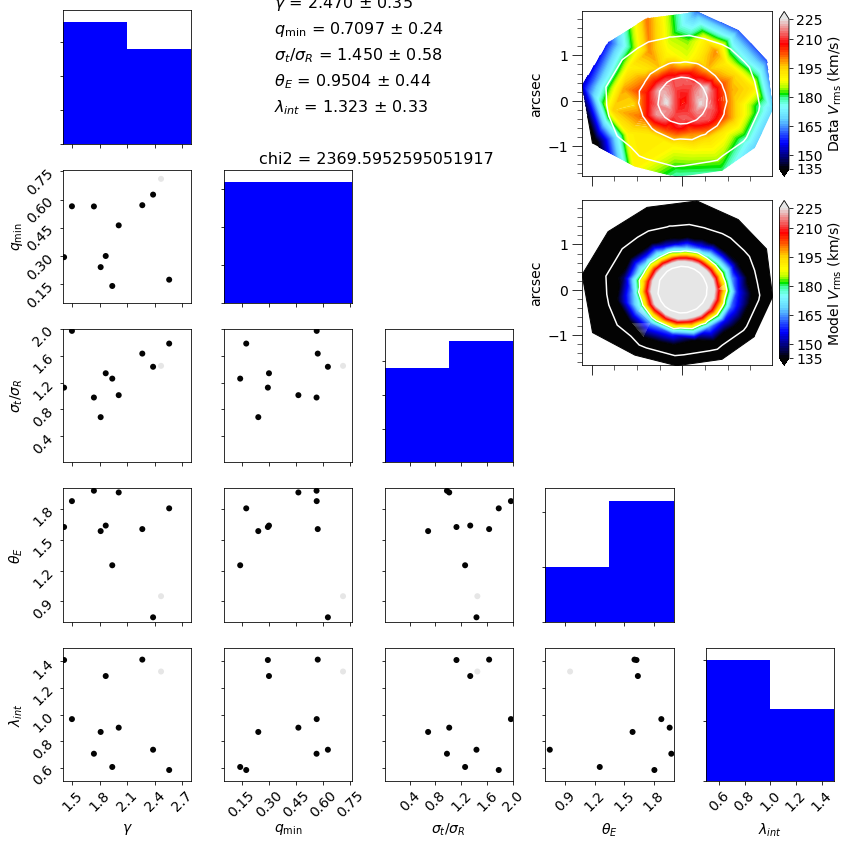

Inclination:  67.48637976884218
########################################################
We've been... JAMMED! On to the next?
########################################################
########################################################
Commencing JAM routine with model power_law, anisotropy const, and alignment cyl... lensprior... number of steps 1
Current date and time is 2023_09_11-02_12_28_PM
JAMMING.
########################################################
p0 [2.47, 0.4, 0.9, 0.951, 1.0]
bounds [[1.4, 0.051, 0.01, 0.7, 0.5], [2.8, 0.7592429227715713, 2.0, 2.0, 1.5]]
sigpar [0.08  0.2   0.2   0.003 0.2  ]
prior_type ['gaussian', 'uniform', 'uniform', 'gaussian', 'uniform']
loaded dVrms:  [ 5.94310903  6.01815848  5.58577453  5.32045051  6.13150797  6.64886809
  7.43281556  7.17730667  6.84494744  6.41455306  7.03079925  6.36942682
  5.77407684  6.76339928  9.77316113  6.74742449  7.62043931 12.44355985
 10.03373272 10.88368898 12.27479565 14.12501264 10.35172239 12.38483952
 13

  0%|          | 0/1 [00:00<?, ?it/s]/home/shawnknabel/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

n accepted unique parameters 16
power_law
JAMMING the best fit model


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/sit


Best-fitting parameters and 1sigma errors:
   $\gamma$ = 2.331 +/- 0.46
   $q_{\rm min}$ = 0.1695 +/- 0.13
   $\sigma_t/\sigma_R$ = 0.6798 +/- 0.20
   $\theta_E$ = 1.015 +/- 0.39
   $\lambda_{int}$ = 1.005 +/- 0.35


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


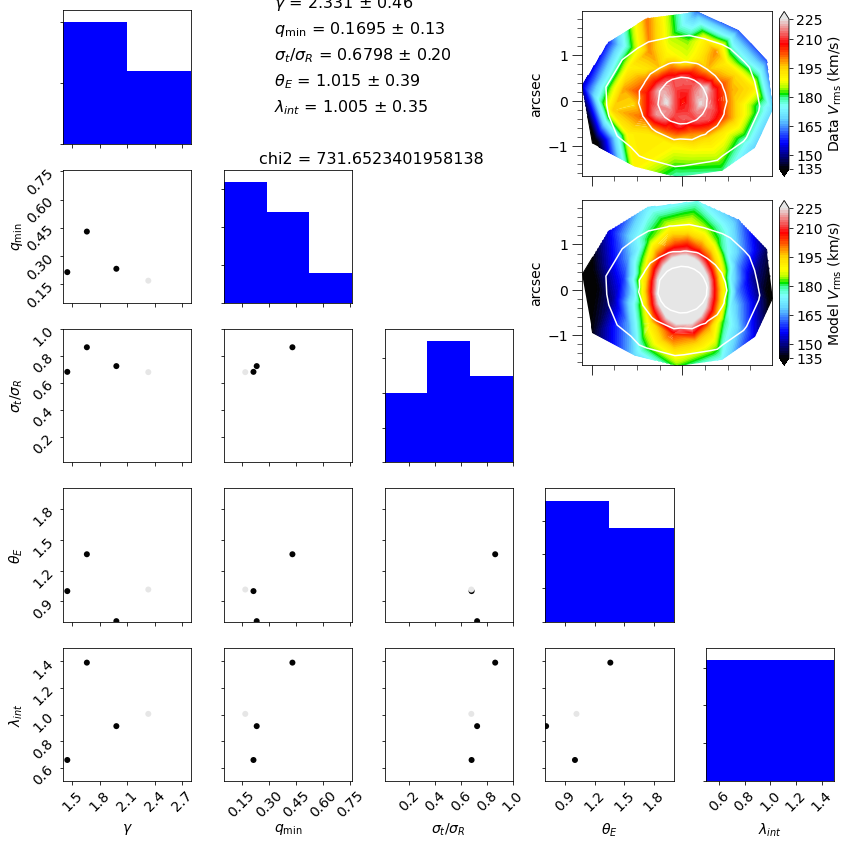

Inclination:  41.32742433136527
########################################################
We've been... JAMMED! On to the next?
########################################################
########################################################
Commencing JAM routine with model power_law, anisotropy OM, and alignment sph... lensprior... number of steps 1
Current date and time is 2023_09_11-02_12_49_PM
JAMMING.
########################################################
p0 [2.47, 0.4, 2.0, 0.951, 1.0]
bounds [[1.4, 0.051, 0.1, 0.7, 0.5], [2.8, 1.0, 5.0, 2.0, 1.5]]
sigpar [0.08  0.2   0.2   0.003 0.2  ]
prior_type ['gaussian', 'uniform', 'uniform', 'gaussian', 'uniform']
loaded dVrms:  [ 5.94310903  6.01815848  5.58577453  5.32045051  6.13150797  6.64886809
  7.43281556  7.17730667  6.84494744  6.41455306  7.03079925  6.36942682
  5.77407684  6.76339928  9.77316113  6.74742449  7.62043931 12.44355985
 10.03373272 10.88368898 12.27479565 14.12501264 10.35172239 12.38483952
 13.67330235 11.306605

100%|██████████| 1/1 [01:08<00:00, 68.36s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

n accepted unique parameters 16
power_law
JAMMING the best fit model


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)



Best-fitting parameters and 1sigma errors:
   $\gamma$ = 1.799 +/- 0.45
   $q_{\rm min}$ = 0.05513 +/- 0.20
   $a_{ani}$ = 0.1583 +/- 0.54
   $\theta_E$ = 0.9719 +/- 0.31
   $\lambda_{int}$ = 0.6486 +/- 0.38


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/sit

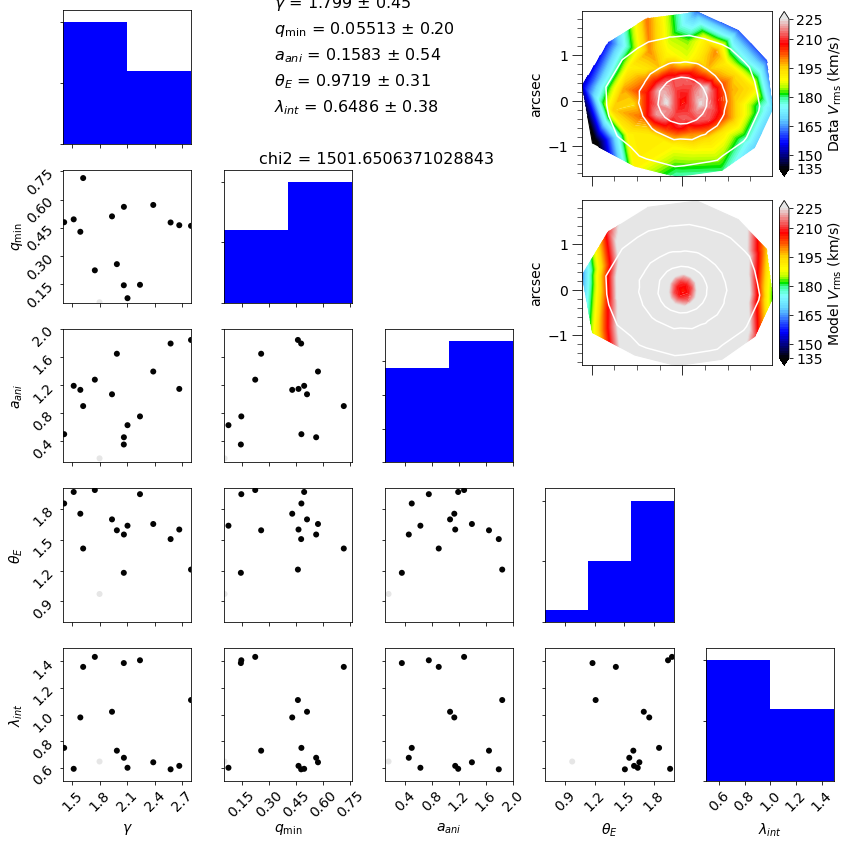

Inclination:  40.677338598440166
########################################################
We've been... JAMMED! On to the next?
########################################################
########################################################
Commencing JAM routine with model power_law, anisotropy OM, and alignment cyl... lensprior... number of steps 1
Current date and time is 2023_09_11-02_16_19_PM
JAMMING.
########################################################
p0 [2.47, 0.4, 2.0, 0.951, 1.0]
bounds [[1.4, 0.051, 0.1, 0.7, 0.5], [2.8, 0.7592429227715713, 2.0, 2.0, 1.5]]
sigpar [0.08  0.2   0.2   0.003 0.2  ]
prior_type ['gaussian', 'uniform', 'uniform', 'gaussian', 'uniform']
loaded dVrms:  [ 5.94310903  6.01815848  5.58577453  5.32045051  6.13150797  6.64886809
  7.43281556  7.17730667  6.84494744  6.41455306  7.03079925  6.36942682
  5.77407684  6.76339928  9.77316113  6.74742449  7.62043931 12.44355985
 10.03373272 10.88368898 12.27479565 14.12501264 10.35172239 12.38483952
 13.67

Traceback (most recent call last):
  File "/home/shawnknabel/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-14-5de7eaaea88b>", line 62, in jam_lnprob
    plot=plot)
  File "<ipython-input-18-70c17b33573c>", line 74, in total_mass_mge
    surf_pot, sigma_pot, qobs_pot = power_law_mge(gamma, theta_E, q_mean, rbreak, lambda_int, rs_mst, zlens, zsource, plot)
  File "<ipython-input-16-87ba2a7b3030>", line 34, in power_law_mge
    m = mge_fit_1d(r, surf_mass_dens, ngauss=20, inner_slope=20, outer_slope=0, quiet=1, plot=plot) # this creates a circular gaussian with sigma=sigma_x (i.e. along the major axis)
  File "/home/shawnknabel/.local/lib/python3.7/site-packages/mgefit/mge_fit_1d.py", line 272, in __init__
    nprint=10, parinfo=parinfo, quiet=quiet)
  File "/home/shawnknabel/.local/lib/python3.7/site-packages/mgefit/cap_mpfit.py", line 1135, in __init__
    wa4[j:] -= fj * np.sum(fj*wa4[

KeyboardInterrupt: 

In [36]:
# set mass model, anisotropy, and alignment
models = ['power_law','nfw']
anis = ['const','OM']
aligns = ['sph', 'cyl']
lenspriors = ['lensprior','nolensprior']
#scale_radii = np.arange(0.1, 0.6, 0.1) # 10*reff to 50*reff
rs_mst = 0.3 # scale radius for mass sheet

# set nstep
nstep= 100 # 100
nwalkers= 32 # 32

print('Thank you for choosing MiseryBot 9.3.2, where you will hate everything and probably quit after a short while.')
print('...')
print('Please hold...')
print('...')
print('Ah yes, the JAM routine. This one is fun.')
print('...')
print('But where to start?')
print('...')

date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p")
print(f'Current date is {date_time}. Hopefully tomorrow will be better.')


print('########################################################')
print('########################################################')

for i, obj_name in enumerate(active_obj_names):
    
    print(f'Jamming object {obj_name}.')
    print('Brace for jamming.')

    print('########################################################') 
    
    for j, SN in enumerate([vorbin_SN_targets[1]]):
        
        print(f'Designated target is S/N {SN}.')
        
        for k, model in enumerate([models[0]]):
            for l, anisotropy in enumerate(anis):#[anis[0]]):
                for m, align in enumerate(aligns):#[aligns[0]]):
                    for n, lensprior in enumerate([lenspriors[0]]):

                        print(f'Commencing JAM routine with model {model}, anisotropy {anisotropy}, and alignment {align}... {lensprior}... number of steps {nstep}')
                        print(f'Current date and time is {tick()}')
                        print('JAMMING.')
                        print('########################################################') 

                        if model=='power_law' and anisotropy=='const':
                            p0 = p0_pow_const
                            bounds = bounds_pow_const
                            sigpar = sigpar_pow_const
                            # take lens priors lensprior = 'lensprior'
                            if lensprior=='lensprior':
                                # update lensing priors
                                lens_model = lens_models[lens_models['obj_name']==obj_name]
                                p0[0] = lens_model['gamma'].iloc[0] #power_law_slopes.iloc[obj_name].iloc[i, 1]
                                sigpar[0] = lens_model['dgamma'].iloc[0]
                                p0[3] = lens_model['theta_E'].iloc[0]
                                sigpar[3] = lens_model['dtheta_E'].iloc[0]
                                prior_type=['gaussian','uniform','uniform','gaussian','uniform']

                        if model=='power_law' and anisotropy=='OM':
                            p0 = p0_pow_om
                            bounds = bounds_pow_om
                            sigpar = sigpar_pow_om
                            # take lens priors lensprior = 'lensprior'
                            if lensprior=='lensprior':
                                # update lensing priors
                                lens_model = lens_models[lens_models['obj_name']==obj_name]
                                p0[0] = lens_model['gamma'].iloc[0] #power_law_slopes.iloc[obj_name].iloc[i, 1]
                                sigpar[0] = lens_model['dgamma'].iloc[0]
                                p0[3] = lens_model['theta_E'].iloc[0]
                                sigpar[3] = lens_model['dtheta_E'].iloc[0]
                                prior_type=['gaussian','uniform','uniform','gaussian','uniform']

                        if model=='nfw' and anisotropy=='const':
                            p0 = p0_nfw_const
                            bounds = bounds_nfw_const
                            sigpar = sigpar_nfw_const
                            if lensprior=='lensprior':
                                print('No lens prior for NFW.')
                                print('########################################################') 
                                print("No JAM! On to the next?")
                                print('########################################################') 
                                print('########################################################')
                                continue

                        if model=='nfw' and anisotropy=='OM':
                            p0 = p0_nfw_om
                            bounds = bounds_nfw_om
                            sigpar = sigpar_nfw_om
                            if lensprior=='lensprior':
                                print('No lens prior for NFW.')
                                print('########################################################') 
                                print("No JAM! On to the next?")
                                print('########################################################') 
                                print('########################################################')
                                continue

                        # sampler args for emcee
                        ndim = len(p0)
                        sampler_args = [nstep, nwalkers, ndim] # 10 walkers

                        print('p0', p0)
                        print('bounds', bounds)
                        print('sigpar', sigpar)
                        print('prior_type', prior_type)

                        space_jam (obj_name, SN, model, anisotropy, align, sampler='emcee', sampler_args=sampler_args, \
                                   rs_mst=rs_mst, \
                                   p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, \
                                   date_time=date_time, overwrite=True, run_id=1)

                        print('########################################################') 
                        print("We've been... JAMMED! On to the next?")
                        print('########################################################') 
                        print('########################################################') 

print(f'Okay, all done as of {tick()}. Thank you for using MiseryBot 9.1.3. We deprecated while you were away. Hope you data is not corrupted.')


__________________
__________________

# BREAK
__________________
__________________